# Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint

In [2]:
#@title Turkish StopWords

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahmetcoskun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Influencer Category Classification



1.   Read Data
2.   Preprocess Data
3.   Prepare Model
4.   Predict Test Data
4.   Save outputs



In [3]:
train_classification_df = pd.read_csv("/Users/ahmetcoskun/Desktop/train-classification.csv",)
train_classification_df = train_classification_df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})

# Unifying labels
train_classification_df["category"] = train_classification_df["category"].apply(str.lower)
username2_category = train_classification_df.set_index("user_id").to_dict()["category"]

In [4]:
# stats about the labels
train_classification_df.groupby("category").count()

,user_id
category,
art,191
entertainment,323
fashion,299
food,511
gaming,13
health and lifestyle,503
mom and children,149
sports,113
tech,346


In [5]:
username2_category["kod8net"]

'tech'

In [6]:
train_data_path = "/Users/ahmetcoskun/Desktop/training-dataset.jsonl"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()


with open(train_data_path, "rt") as fh:
  for line in fh:
    sample = json.loads(line)

    profile = sample["profile"]
    username = profile["username"]
    if username in username2_category:
      # train data info
      username2posts_train[username] = sample["posts"]
      username2profile_train[username] = profile


    else:
      # it is test data info
      username2posts_test[username] = sample["posts"]
      username2profile_test[username] = profile


In [7]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

train_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [8]:
test_profile_df.head(2)

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

def preprocess_text(text: str):
    # lower casing Turkish Text, Don't use str.lower :)
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation
    # HERE THE EMOJIS stuff are being removed, you may want to keep them :D
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


corpus = []

# to keep the label order
train_usernames = []

for username, posts in username2posts_train.items():
  train_usernames.append(username)

  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  ## Adding category_name to the strings used as features
  cname = username2profile_train[username]["category_name"]

  if cname is not None:
    cname = preprocess_text(cname)
    cleaned_captions.append(cname)

  ##


  # joining the posts of each user with a \n
  user_post_captions = "\n".join(cleaned_captions)
  corpus.append(user_post_captions)


vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=5000)

# fit the vectorizer
vectorizer.fit(corpus)


# transform the data into vectors
x_post_train = vectorizer.transform(corpus)
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]


test_usernames = []
test_corpus = []
for username, posts in username2posts_test.items():
  test_usernames.append(username)
  # aggregating the posts per user
  cleaned_captions = []
  for post in posts:
    post_caption = post.get("caption", "")
    if post_caption is None:
      continue

    post_caption = preprocess_text(post_caption)

    if post_caption != "":
      cleaned_captions.append(post_caption)


  ## Adding category_name to the strings used as features
  cname = username2profile_test[username]["category_name"]

  if cname is not None:
    cname = preprocess_text(cname)
    cleaned_captions.append(cname)

  ##

  user_post_captions = "\n".join(cleaned_captions)
  test_corpus.append(user_post_captions)


# Just transforming! No Fitting!!!!!
x_post_test = vectorizer.transform(test_corpus)

In [10]:
# Making sure everything is fine
assert y_train.count("NA") == 0

In [11]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['abdullah', 'abone', 'about', ..., 'şık', 'şıklık', 'şıklığı'],
      dtype=object)

In [12]:
df_tfidf = pd.DataFrame(x_post_train.toarray(), columns=feature_names)
df_tfidf.head(2)

,abdullah,abone,about,accompanied,acele,acil,activities,acı,ad,ada,...,şubemiz,şubesi,şölen,şöleni,şöyle,şükranla,şükür,şık,şıklık,şıklığı
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050424,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [13]:
df_tfidf.shape

(2741, 5000)

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_tfidf, y_train, test_size=0.2, stratify=y_train)

In [15]:
x_train.shape

(2192, 5000)

In [16]:
x_val.shape

(549, 5000)

Model Training

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize individual models
random_forest = RandomForestClassifier(random_state=42)
svm = SVC(probability=True, random_state=42)
naive_bayes = MultinomialNB()
gradient_boosting = GradientBoostingClassifier(random_state=42)



# Create a VotingClassifier ensemble
ensemble = VotingClassifier(
    estimators=[
        ('rf', random_forest),
        ('svm', svm),
        ('nb', naive_bayes),
        ('gb', gradient_boosting)
    ],
    voting='soft'  # 'soft' for using predicted probabilities, 'hard' for majority voting
)

# Fit the ensemble on the training data
ensemble.fit(x_train, y_train)

# Predict on the validation set
y_pred = ensemble.predict(x_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_val, y_pred))


Accuracy: 0.6740
Classification Report:
                      precision    recall  f1-score   support

                 art       0.38      0.16      0.22        38
       entertainment       0.52      0.52      0.52        65
             fashion       0.66      0.68      0.67        60
                food       0.86      0.87      0.86       102
              gaming       1.00      0.33      0.50         3
health and lifestyle       0.61      0.78      0.69       100
    mom and children       0.70      0.47      0.56        30
              sports       0.79      0.48      0.59        23
                tech       0.69      0.81      0.75        69
              travel       0.68      0.68      0.68        59

            accuracy                           0.67       549
           macro avg       0.69      0.58      0.60       549
        weighted avg       0.67      0.67      0.66       549



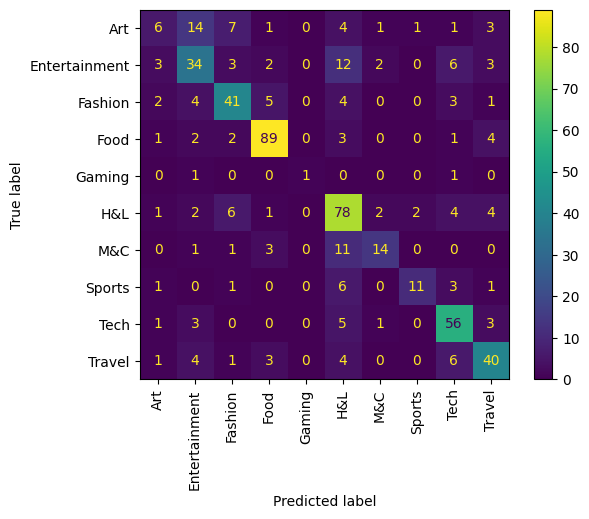

In [18]:
# Display the confusion matrix

import matplotlib.pyplot as plt
from sklearn import metrics
listOfClasses = ["Art", "Entertainment", "Fashion", "Food", "Gaming", "H&L", "M&C", "Sports","Tech","Travel"]
confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = listOfClasses)
cm_display.plot()
plt.xticks(rotation=90)
plt.show()